In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Loading Dependencies

In [2]:
#first of All we need to install some necessary libraries and packages for our work
# to do that  we need to start with the codes below
!pip install split-folders
!pip install pydot

import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import shutil

from keras import Sequential
from keras import layers
from keras.layers.experimental import preprocessing
from keras.callbacks import EarlyStopping

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import minmax_scale

## Setting the seed

In [3]:
# To get repeatable results we need to set our seed with the exactly same integer
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## Loading our online dataset 


In [4]:
#Because of our dataset is located on Google`s cloud drives
#we need to get access on it
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AHBngICUJxH3PXqVl6hAR5H76KDpOUEsgFn_ViQIYEDH7TF4eLRn5w
Mounted at /content/drive


## Extraction of the zipped file

In [5]:
#Our dataset is zipped and uploaded to Google`s Cloud for more efficiently storage and faster connection purposes
#that`s why we need to unzip our dataset whose name is data.zip
zip_path = "/content/drive/My Drive/Covid/data.zip"
with ZipFile(zip_path, "r") as zip_obj:
    zip_obj.extractall("/content/")

## Creating the folder that we`ll use

In [6]:
#We need to split our dataset into 3 partitions which would be 1-train partition, 2-validation partition and 3-test partition
if os.path.exists("/content/data2/"):
    shutil.rmtree("/content/data2/")

input_folder = "/content/data/"
output_folder = "/content/data2/"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
#Let`s split our data into the three partitions with ratio of 0.6, 0.2 and 0.2 ( for the train data 0.6 + for the validation data 0.2 + for the test data 0.2 = 1 )
splitfolders.ratio(input_folder, output=output_folder, seed=seed, ratio=(0.6, 0.2, 0.2), group_prefix=None)


Copying files: 8049 files [01:09, 115.08 files/s]


## The Image Generator

In [7]:
#Because of our data is health data and generally health data are not evenly distributed , So we need to use an image generator to get more efficiently model
# Let`s specify our image`s size and our batch size
image_size = (300, 300)
batch_size = 64

# Let`s map our directories` paths
train_path = "/content/data2/train"
val_path = "/content/data2/val"
test_path = "/content/data2/test"

# Let`s name our classes
# for detection of bacterial pneumonia we`ll use the "bacterial" class
# for detection of viral pneumonia we`ll use the "viral" class
# for detection of covid19 pneumonia we`ll use the "covid19" class
# for detection of healthy cases we`ll use the "normal" class
class_names=["bacterial", "covid19", "normal", "viral"]


#Let`s generate our datasets with our image generator
train_ds = image_dataset_from_directory(directory=train_path,
                                        class_names=class_names,
                                        batch_size=batch_size,
                                        seed=seed,
                                        image_size=image_size)

val_ds = image_dataset_from_directory(directory=val_path,
                                        class_names=class_names,
                                        batch_size=batch_size,
                                        seed=seed,
                                        image_size=image_size,
                                        shuffle=False)

test_ds= image_dataset_from_directory(directory=test_path,
                                      class_names=class_names,
                                      batch_size=1,
                                      seed=seed,
                                      image_size=image_size,
                                      shuffle=False)

Found 4829 files belonging to 4 classes.
Found 1609 files belonging to 4 classes.
Found 1611 files belonging to 4 classes.


## Some minor tunnig for the improved perfomance

In [8]:
#Let`s configure the dataset to get better performance
train_ds = train_ds.prefetch(buffer_size=batch_size)
val_ds = train_ds.prefetch(buffer_size=batch_size)
test_ds = test_ds.prefetch(buffer_size=batch_size)

## Some visualizations of our image samples

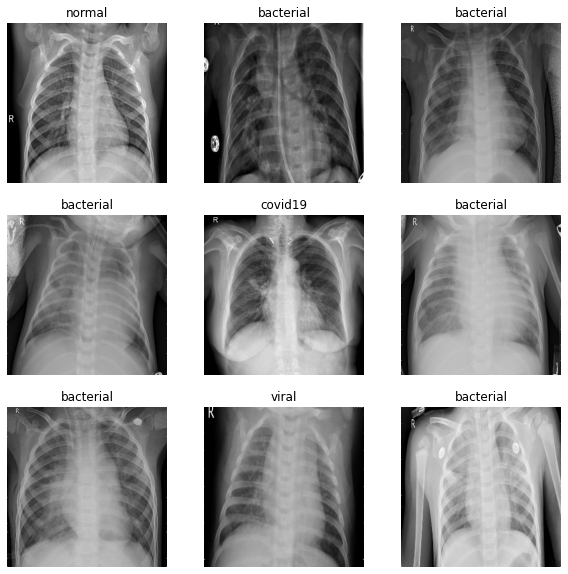

In [9]:
#Let`s show some visualizations of our samples
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

## The image data augmentation

In [10]:
#Let`s make some augmentations on our data
data_augmentation = Sequential(name="augmentation")
data_augmentation.add(preprocessing.RandomRotation(factor=(-0.02,0.02),fill_mode="constant"))
data_augmentation.add(preprocessing.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1),fill_mode="constant"))
data_augmentation.add(preprocessing.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1),fill_mode="constant"))
data_augmentation.add(preprocessing.RandomContrast(0.25))

## Some visualizations of our just augmented samples

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


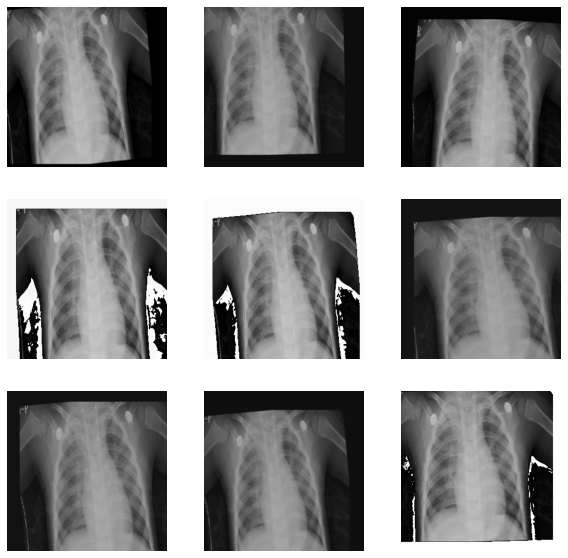

In [11]:
#After making some augmentations on our data let`s show some augmented samples
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Our Machine Learning Model

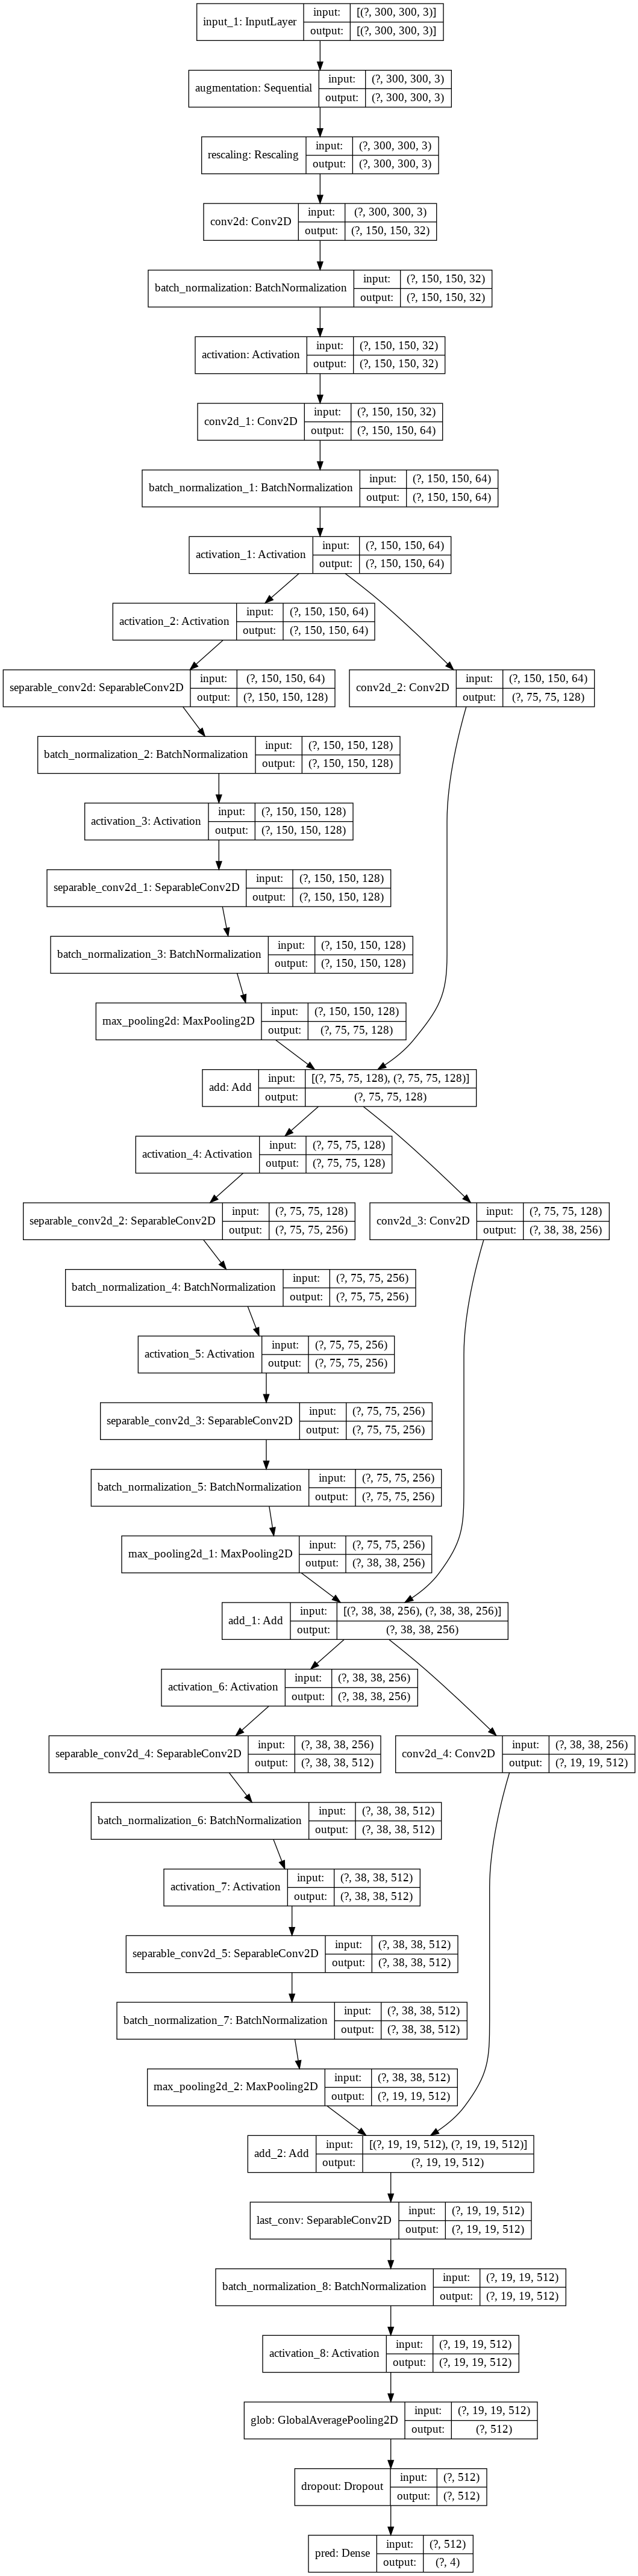

In [12]:
#Before training our model to get higher accuracy levels from our model we can apply some standartation methods on our data

#Let`s shape our data first
input_shape = (image_size[0], image_size[1], 3)
inputs = keras.Input(shape=input_shape)



# to use artificially increased amount of image samples
x = data_augmentation(inputs)


# Let`s convert our color scale from 0-255 to 0-1 with dividing it by 255
x = preprocessing.Rescaling(1.0 / 255)(x)

#The first layer of data in our machine learning model

x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

#Let`s set aside the residuals for in case of the need of using them later
previous_block_activation = x  

# the numbers of the neurons on the layers we use on our model which are 128, 256, 512.
for size in [128, 256, 512]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # the residual of our process
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

x = layers.SeparableConv2D(512, 3, padding="same", name="last_conv")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D(name="glob")(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax", name="pred")(x)
model = keras.Model(inputs, outputs)

#After trying some optimizers and other loss functions on our model we`ve selected "Adam optimizer" as 
#our optimizer and "sparse_categorical_crossentropy" as our loss function

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Let`s plot our model to show its layers more understandable way
keras.utils.plot_model(model, show_shapes=True)

## Training Step of Our Machine learning Model

In [13]:
#Let`s train our model
#Let`s set the epochs which means how many steps would our model take
epochs = 100
early_stop = EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True)
history = model.fit(train_ds, 
          epochs=epochs, 
          callbacks=[early_stop], 
          validation_data=val_ds,
          validation_freq=1,
          workers=-1,
          use_multiprocessing=True)

Epoch 1/100
76/76 [==============================] - 168s 2s/step - loss: 0.8640 - accuracy: 0.6384 - val_loss: 1.4811 - val_accuracy: 0.3106
Epoch 2/100
76/76 [==============================] - 164s 2s/step - loss: 0.6430 - accuracy: 0.7360 - val_loss: 1.9255 - val_accuracy: 0.3110
Epoch 3/100
76/76 [==============================] - 164s 2s/step - loss: 0.5579 - accuracy: 0.7629 - val_loss: 2.6726 - val_accuracy: 0.3106
Epoch 4/100
76/76 [==============================] - 164s 2s/step - loss: 0.5100 - accuracy: 0.7840 - val_loss: 3.8979 - val_accuracy: 0.3106
Epoch 5/100
76/76 [==============================] - 163s 2s/step - loss: 0.4816 - accuracy: 0.8014 - val_loss: 5.0906 - val_accuracy: 0.2539
Epoch 6/100
76/76 [==============================] - 164s 2s/step - loss: 0.4539 - accuracy: 0.8147 - val_loss: 7.1088 - val_accuracy: 0.2539
Epoch 7/100
76/76 [==============================] - 165s 2s/step - loss: 0.4441 - accuracy: 0.8147 - val_loss: 3.8367 - val_accuracy: 0.3653
Epoch 

## Visualition of the accuracies of our just trained model wegwe hbhb

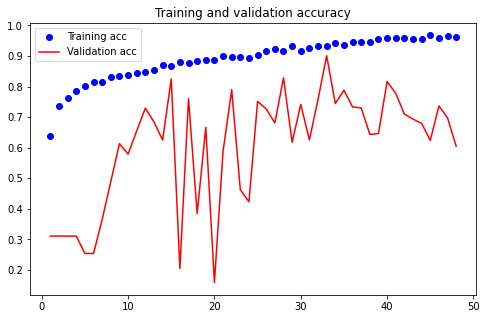

In [24]:
#Let`s visualize the accuracies of our just trained model on our training dataset and test dataset
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

##Let`s visualize the loss functions of our just trained model

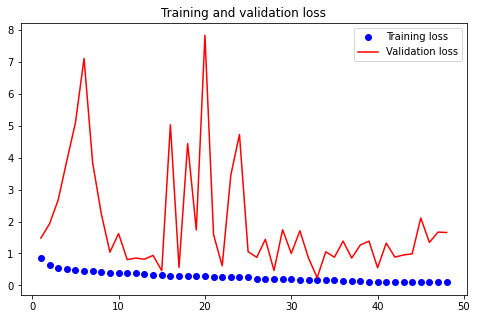

In [15]:
#Let`s visualize the accuracy of our just trained model
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Visualition of the accuracy of our just trained model 

## Save and Load the model

In [17]:
#Let`s save our model for our future improved works
# model.save("/content/drive/My Drive/Covid/saved_model_deep_final_cem.hdf5", overwrite=True)
#model = keras.models.load_model("/content/drive/My Drive/Covid/saved_model_deep_final_cem.hdf5")

## The Evaluation of the model

In [18]:
#Let`s evaluate our model performance on test dataset
# To do that Let`s start with its performance on test dataset
from sklearn.metrics import accuracy_score
y_score = model.predict(test_ds)
y_pred = np.argmax(y_score, axis=1)
y_true = np.array([x[1].numpy() for x in list(test_ds)])

test_acc = accuracy_score(y_true, y_pred)
print("Test Accuracy: {:0.4f}\n".format(test_acc))

Test Accuracy: 0.8367



## The Confusion Matrix of our predictions

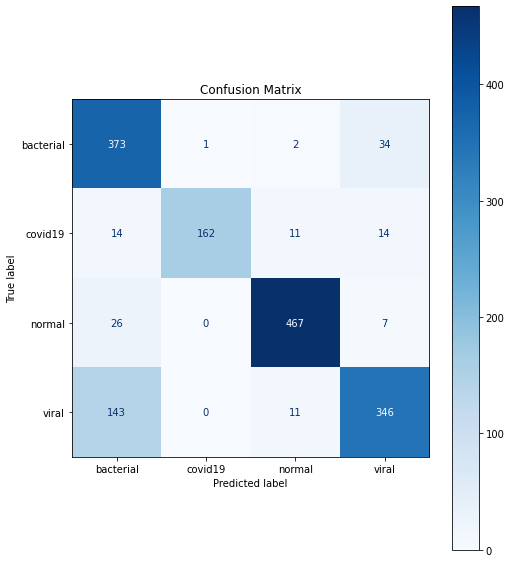

In [19]:
# To show how many samples of our dataset are predicted correctly let`s draw our confusion matrix
conf = confusion_matrix(y_true, y_pred)
conf_im = ConfusionMatrixDisplay(conf, class_names)
conf_im.plot(values_format="d",cmap=plt.cm.Blues)
fig = plt.gcf()
fig.set_size_inches(8, 10)
plt.title("Confusion Matrix")
plt.show()

## Receiver Operating Characteristic - The ROC Curve


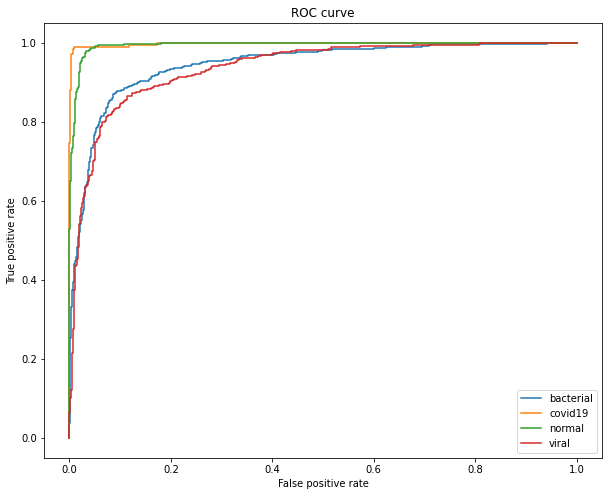

In [20]:
# Let`s illustrate our Receiver operating characteristic curve , shortly ROC curve, to show our model`s efficiency
plt.figure(figsize=(10, 8))
for i in range(4):
    y_bin = label_binarize(y_true, [0, 1, 2, 3])
    fpr, tpr, _ = roc_curve(y_bin[:,i], y_score[:,i])
    plt.plot(fpr, tpr, label=class_names[i])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()


## The visualiton of what we have found 

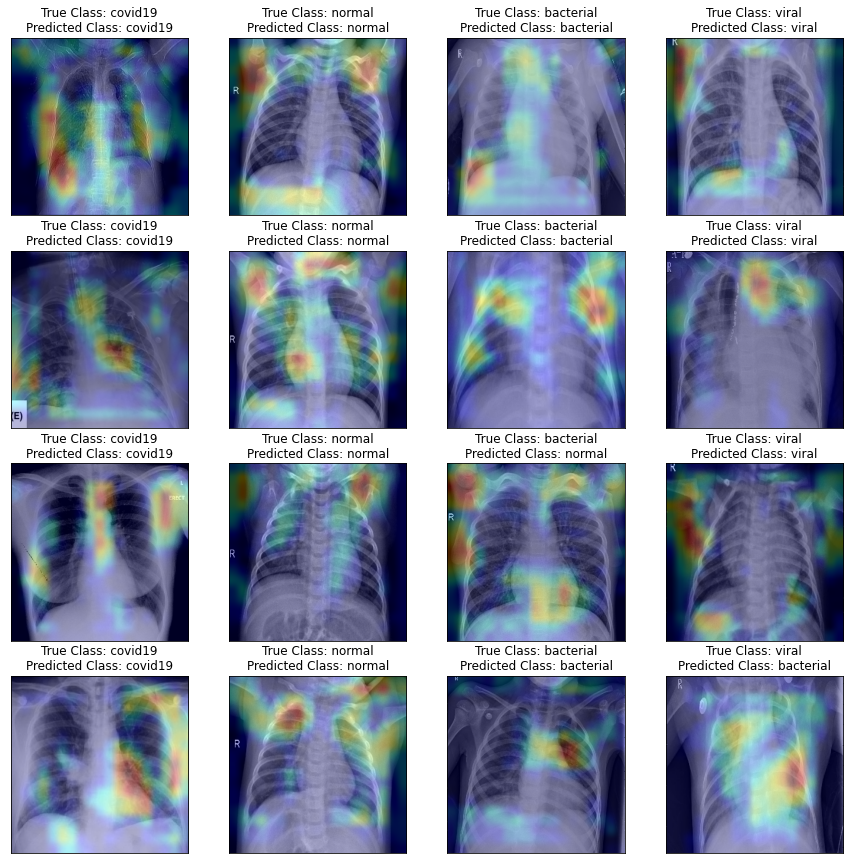

In [21]:
#After that point we`ll give some visualizations on what we have found with help of our model


#Let`s start with illustration of heat maps

def make_gradcam_heatmap(img, size, model, last_conv_layer_name, classifier_layer_names):
    img_array = keras.preprocessing.image.img_to_array(img)
    # Let`s transform the array which we`ve used into a batch
    img_array = np.expand_dims(img_array, axis=0)

    # Let`s create a new class name for the predictions
    y_pred = np.argmax(model.predict(img_array), axis=1)
    y_pred = class_names[int(y_pred)]
    # Let`s create a model that maps the input image sample to the activations of the last convulation layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # After that Let`s create another model that maps the activations of the last convulation
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    #And then, Let`s compute the gradients of the top predicted class for our input image samples
    # with respect to the activations of the last convulation layer
    with tf.GradientTape() as tape:
        # Let`s compute the activations of the last convulation layer and Let`s create a tape function to monitor it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Let`s compute the class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # Let`s arrange the gradient of the top predicted class on the output feature map of the last convulation layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Let`s arrange a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We can multiply each channel on the feature map array by
    # the coefficient which is "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we can also normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    # Let`s rescale the heatmap to the range between 0-255 as we done on the standartation above
    heatmap = np.uint8(255 * heatmap)

    # Let`s use jet colormap to colorize the heatmap
    jet = plt.cm.jet

    # Let`s use RGB values of the colormap to make them more obvious
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Let`s create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[2], img_array.shape[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Let`s superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img, y_pred
    

# Now we`r ready to the illustration of the heatmap
last_conv_layer_name = "last_conv"
classifier_layer_names = ["glob", "pred"]
i = 1
plt.figure(figsize=(15, 15))
np.seterr(divide='ignore', invalid='ignore')
for idx in [9, 3, 81, 12]:
    for y_true in ["covid19", "normal", "bacterial", "viral"]:
        img_path = "/content/data2/test/" + y_true + "/" + os.listdir("/content/data2/test/" + y_true)[idx]
        # to get an image sample from our disk
        img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
        # to plot the heat map
        image, y_pred = make_gradcam_heatmap(img, image_size, model, last_conv_layer_name, classifier_layer_names)
        plt.subplot(4, 4, i)
        plt.imshow(image)
        plt.title("True Class: " + y_true + "\nPredicted Class: " + y_pred)
        plt.xticks([])
        plt.yticks([])
        i = i + 1
plt.show()

## The distrubition of our Test dataset

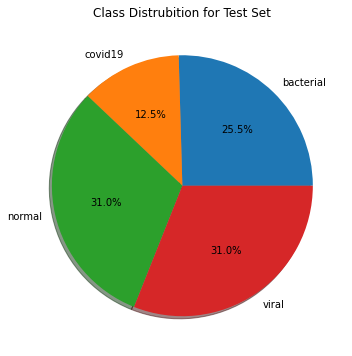

In [22]:
# Let`s draw the class distrubition of our test set
n_bacterial = len(os.listdir("/content/data2/test/bacterial"))
n_covid19 = len(os.listdir("/content/data2/test/covid19"))
n_normal = len(os.listdir("/content/data2/test/normal"))
n_viral= len(os.listdir("/content/data2/test/viral"))

plt.figure(figsize=(6,6))
plt.pie(x=[n_bacterial, n_covid19, n_normal, n_viral], labels=class_names, shadow=True, autopct='%1.1f%%')
plt.title("Class Distrubition for Test Set")
plt.show()

## The ratios of our predictions

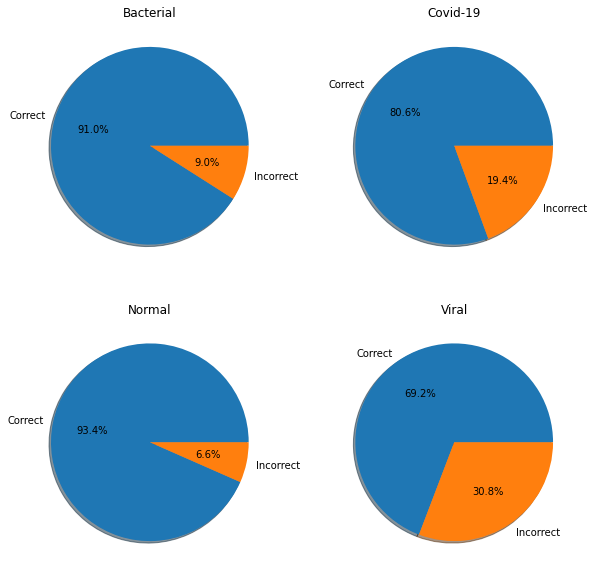

In [23]:
#Let`s show how many correct and wrong predictions we have with the pie charts
n_bac = np.sum(conf[0,:])
t_bac = conf[0,0]

n_cov = np.sum(conf[1,:])
t_cov= conf[1,1]

n_nor = np.sum(conf[2,:])
t_nor = conf[2,2]

n_vir = np.sum(conf[3,:])
t_vir= conf[3,3]

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.pie(x=[t_bac, n_bac-t_bac], labels=["Correct", "Incorrect"], shadow=True, autopct='%1.1f%%')
plt.title("Bacterial")

plt.subplot(2,2,2)
plt.pie(x=[t_cov, n_cov-t_cov], labels=["Correct", "Incorrect"], shadow=True, autopct='%1.1f%%')
plt.title("Covid-19")

plt.subplot(2,2,3)
plt.pie(x=[t_nor, n_nor-t_nor], labels=["Correct", "Incorrect"], shadow=True, autopct='%1.1f%%')
plt.title("Normal")

plt.subplot(2,2,4)
plt.pie(x=[t_vir, n_vir-t_vir], labels=["Correct", "Incorrect"], shadow=True, autopct='%1.1f%%')
plt.title("Viral")
plt.show()